C:\Users\Airly\AppData\Local\Temp\ipykernel_2656\321283780.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times = pd.date_range('2024-01-01', '2025-01-01', freq='1H', tz=tz)
C:\Users\Airly\AppData\Local\Temp\ipykernel_2656\321283780.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ghi_adj, dni_adj, dhi_adj = adjust_for_cloudiness(clearsky['ghi'][i], clearsky['dni'][i], clearsky['dhi'][i], cloudiness[i])


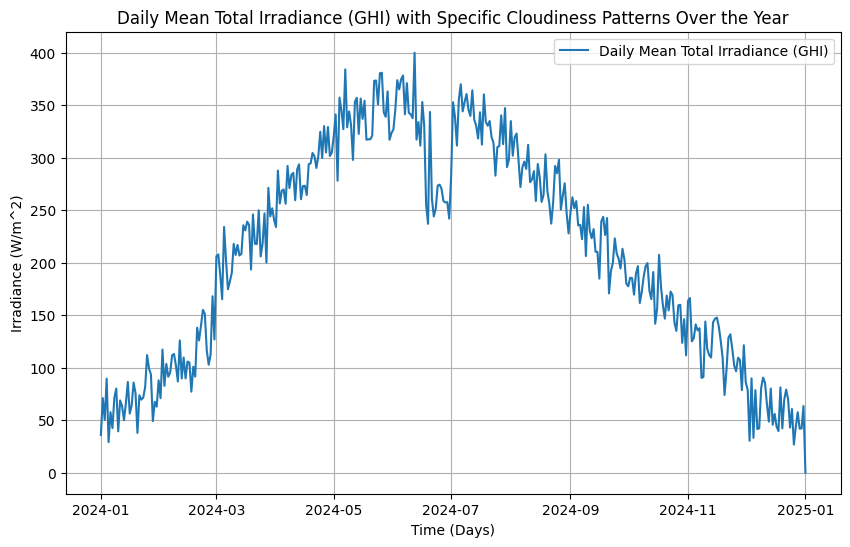

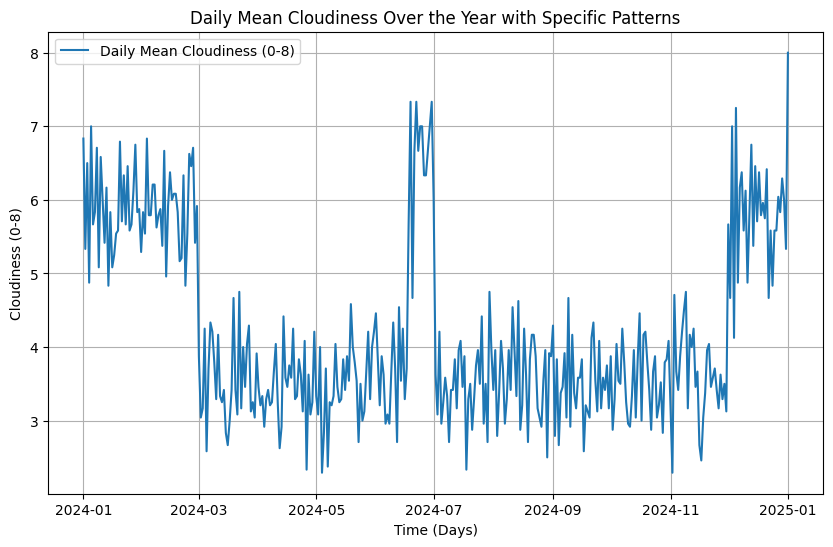

In [5]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pvlib.location import Location

# Funkcja do modyfikacji irradiancji w zależności od zachmurzenia
def adjust_for_cloudiness(ghi, dni, dhi, cloudiness):
    """
    Adjust the irradiance based on cloudiness (0-8 scale).
    Cloudiness 0 = clear sky, 8 = fully overcast.
    """
    # Skalowanie bezpośredniego promieniowania: im większe zachmurzenie, tym mniej promieniowania bezpośredniego
    dni_adj = dni * (1 - (cloudiness / 8))
    
    # Skalowanie rozproszonego promieniowania: im większe zachmurzenie, tym więcej promieniowania rozproszonego
    dhi_adj = dhi + (ghi * (cloudiness / 8) * 0.5)  # Zakładamy, że połowa promieniowania zamienia się w rozproszone
    
    # GHI pozostaje zbliżone, ponieważ jest to suma promieniowania bezpośredniego i rozproszonego
    ghi_adj = dni_adj + dhi_adj
    
    return ghi_adj, dni_adj, dhi_adj

# Ustawienia lokalizacji
latitude = 52.2297  # Warszawa, Polska
longitude = 21.0122
altitude = 100  # metry nad poziomem morza
tz = 'Europe/Warsaw'

# Przedział czasu - cały rok (2024), co godzinę
times = pd.date_range('2024-01-01', '2025-01-01', freq='1H', tz=tz)

# Lokalizacja
site_location = Location(latitude, longitude, tz=tz, altitude=altitude)

# Pozycja słoneczna dla danej lokalizacji i czasu
solar_position = site_location.get_solarposition(times)

# Model czystego nieba (model Ineichen)
clearsky = site_location.get_clearsky(times, model='ineichen')

# Inicjalizacja listy na wartości zachmurzenia
cloudiness = []

# Generowanie wartości zachmurzenia
for time in times:
    month = time.month
    day_of_year = time.dayofyear
    
    # Zima (styczeń, luty, grudzień) – pełne zachmurzenie (8) preferowane
    if month in [1, 2, 12]:
        if np.random.rand() < 0.8:  # 80% szans na pełne zachmurzenie
            cloudiness.append(8)
        else:
            cloudiness.append(np.random.randint(1, 9))  # Losowe zachmurzenie, ale nie 0
    
    # Lato (wybrane dwa tygodnie pełnego zachmurzenia)
    elif month in [6, 7, 8]:
        if 170 <= day_of_year <= 183:  # Dwa tygodnie pełnego zachmurzenia w lecie
            cloudiness.append(8)
        else:
            cloudiness.append(np.random.randint(1, 9))  # Losowe zachmurzenie, ale nie 0
    
    # Pozostałe miesiące – losowe zachmurzenie od 0 do 8
    else:
        cloudiness.append(np.random.randint(1, 9))  # Losowe zachmurzenie, ale nie 0

# Zamiana 20% wartości na 0
cloudiness = np.array(cloudiness)
zero_indices = np.random.choice(range(len(cloudiness)), size=int(0.2 * len(cloudiness)), replace=False)
cloudiness[zero_indices] = 0

# Puste listy do przechowywania wyników dla zmodyfikowanej irradiancji
ghi_adj_list = []
dni_adj_list = []
dhi_adj_list = []

# Obliczanie irradiancji dla każdej godziny z losowym zachmurzeniem
for i in range(len(times)):
    ghi_adj, dni_adj, dhi_adj = adjust_for_cloudiness(clearsky['ghi'][i], clearsky['dni'][i], clearsky['dhi'][i], cloudiness[i])
    ghi_adj_list.append(ghi_adj)
    dni_adj_list.append(dni_adj)
    dhi_adj_list.append(dhi_adj)

# Konwersja list do serii pandas
ghi_adj_series = pd.Series(ghi_adj_list, index=times)

# Obliczenie dobowej średniej irradiancji
daily_mean_ghi = ghi_adj_series.resample('D').mean()

# Wykres dobowej średniej irradiancji
plt.figure(figsize=(10,6))
plt.plot(daily_mean_ghi, label='Daily Mean Total Irradiance (GHI)')
plt.title('Daily Mean Total Irradiance (GHI) with Specific Cloudiness Patterns Over the Year')
plt.ylabel('Irradiance (W/m^2)')
plt.xlabel('Time (Days)')
plt.grid(True)
plt.legend()
plt.show()

# Dodatkowo możemy zwrócić losowe wartości zachmurzenia dla wglądu
cloudiness_series = pd.Series(cloudiness, index=times)
daily_mean_cloudiness = cloudiness_series.resample('D').mean()

# Wykres dobowych średnich wartości zachmurzenia
plt.figure(figsize=(10,6))
plt.plot(daily_mean_cloudiness, label='Daily Mean Cloudiness (0-8)')
plt.title('Daily Mean Cloudiness Over the Year with Specific Patterns')
plt.ylabel('Cloudiness (0-8)')
plt.xlabel('Time (Days)')
plt.grid(True)
plt.legend()
plt.show()

